In [1]:
#Import external packages
import matplotlib.pyplot as plt
import numpy as np
import sys
import random
from scipy.integrate import odeint as ode
import torch
import pandas as pd

In [2]:
#Import local functions
sys.path.append('../functions')
from functions import dual_control_scipy, loss_biological

In [4]:
def simple_solve(alpha1, alpha2):
    '''Solves dual control system for a variety of ks using scipy solvers'''
    #Solve using simple solvers
    ks = np.linspace(1E-7, 0.001, 10)
    theta1 = 0.1

    int_time = 5E4
    t = torch.linspace(0, int_time, 100) 
    y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 

    ss_data = pd.DataFrame(columns=['theta', 'k1', 'k2', 'j1', 'j2', 'loss'])

    for k1 in ks:
        for k2 in ks:
            pred = ode(dual_control_scipy, y0, t, args=(2, 2, theta1, theta1, k1, k2))
            j1, j2, loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)
            row = [theta1, k1, k2, j1, j2, loss]
            ss_data.loc[len(ss_data)] = row
    
    #Compute gradients of loss landscape
    loss = ss_data.pivot_table(index='k1', columns='k2', values='loss').T.values
    j1 = ss_data.pivot_table(index='k1', columns='k2', values='j1').T.values
    j2 = ss_data.pivot_table(index='k1', columns='k2', values='j2').T.values
    k1_unique = np.sort(ss_data.k1.unique())
    k2_unique = np.sort(ss_data.k2.unique())
    k1s, k2s = np.meshgrid(k1_unique, k2_unique)
    gradient = np.gradient(loss)
    #Normalize gradient for vector field
    norm = np.sqrt(gradient[0]**2 + gradient[1]**2)
    norm_grad_x = gradient[0] / norm
    norm_grad_y = gradient[1] / norm
    mag_gradient = gradient[0] + gradient[1]
    return k1s, k2s, j1, j2, loss, gradient, norm_grad_x, norm_grad_y, mag_gradient
    
k1s, k2s, j1, j2, loss_landscape, gradient, norm_grad_x, norm_grad_y, mag_gradient = simple_solve(1E-5, 1E-2)

In [18]:
patch_size = 50
step_size = 0.0001
num_epochs = 10

alpha1 = 1E-5
alpha2 = 1E-2

int_time = 5E4
t = np.linspace(0, int_time, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 
losses = []
theta1 = 0.1
def solve_patch(k1, k2, patch_size, step_size):
    pred = ode(dual_control_scipy, y0, t, args=(2, 2, 0.1, 0.1, k1, k2))
    j1, j2, center_loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)

    #Solve surrounding patch
    thetas = np.linspace(0, 2*np.pi, patch_size)
    k1s = step_size*np.cos(thetas) + k1
    k2s = step_size*np.sin(thetas) + k2

    min_loss = center_loss
    new_k1 = k1
    new_k2 = k2

    for k1, k2 in zip(k1s, k2s):
        pred = ode(dual_control_scipy, y0, t, args=(2, 2, theta1, theta1, k1, k2));
        j1, j2, loss = loss_biological(pred, alpha1=alpha1, alpha2=alpha2)
        if loss < min_loss:
            new_k1 = k1
            new_k2 = k2
            min_loss = loss
    return new_k1, new_k2, min_loss

#Select random initialization and solve once
krange = [1E-7, 0.001]
# k1 = random.uniform(krange[0], krange[1])
# k2 = random.uniform(krange[0], krange[1])
#Set initialization for better visaulization
k2 = 0.0008
k1 = 0.0002

k1_trace = []; k2_trace = []
for i in range(num_epochs):
    new_k1, new_k2, loss = solve_patch(k1, k2, patch_size, step_size)
    k1 = new_k1
    k2 = new_k2
    losses.append(loss)
    k1_trace.append(k1)
    k2_trace.append(k2)


Text(0, 0.5, 'Loss Value')

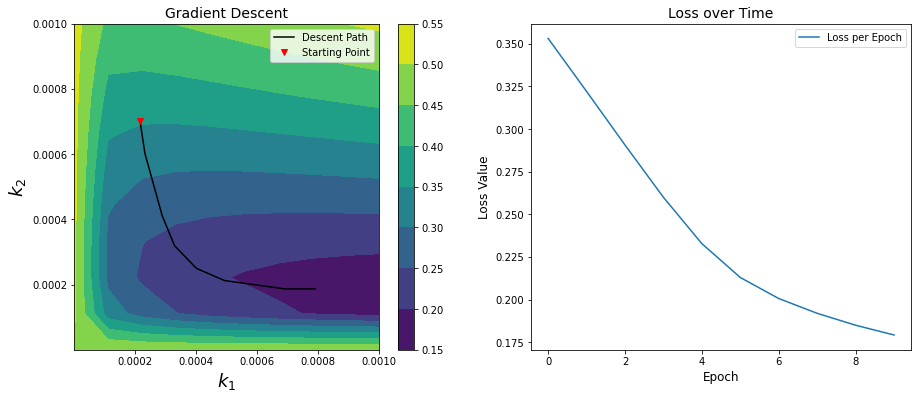

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'Gradient Descent'
ax = axs[0]
contour = ax.contourf(k1s,k2s,loss_landscape)
ax.plot(k1_trace, k2_trace, 'k-', label='Descent Path')
ax.plot(k1_trace[0], k2_trace[0], 'rv', label='Starting Point')
ax.legend()

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('$k_1$', fontsize=18)
ax.set_ylabel('$k_2$', fontsize=18)
fig.colorbar(contour, ax=ax)


endpoint = 'Loss over Time'
ax = axs[1]
ax.plot(losses, label='Loss per Epoch')
ax.legend()

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)

In [ ]:
patch_size = [10, 25, 50, 100]
for p in patch_size:
    thetas = np.linspace(0, 2*np.pi, patch_size)
    new_k1 = k1
    new_k2 = k2
    k1s = step_size*np.cos(thetas) + k1
    k2s = step_size*np.sin(thetas) + k2